In [17]:
import tempfile
import os
import pickle
import torch
import random
import numpy as np

from molecule_featurizer import MoleculeFeaturizer
from litschnet import LitSchNet
from ccdc_rdkit_connector import CcdcRdkitConnector
from ccdc.pharmacophore import Pharmacophore
from ccdc.descriptors import GeometricDescriptors
from ccdc.utilities import Colour
from ccdc import io
from torch_geometric.data import Batch
from ccdc.descriptors import GeometricDescriptors
import seaborn as sns
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

In [18]:
data_dir = '/home/benoit/bioactive_conformation_predictor/data/'
with open(os.path.join(data_dir, 'random_splits', f'test_smiles_random_split_0.txt'), 'r') as f :
    test_smiles = f.readlines()
    test_smiles = [smiles.strip() for smiles in test_smiles]

with open(os.path.join(data_dir, 'raw', 'ccdc_generated_conf_ensemble_library.p'), 'rb') as f :
    cel = pickle.load(f)
    
pdbbind_refined_dir = '/home/benoit/PDBBind/PDBbind_v2020_refined/refined-set/'
pdbbind_general_dir = '/home/benoit/PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/'
connector = CcdcRdkitConnector()

In [19]:
ce = cel.get_conf_ensemble(test_smiles[0])
mol = ce.mol

In [20]:
Pharmacophore.read_feature_definitions()

In [21]:
feature_identifiers = ['donor_projected', 'ring', 'acceptor']
feature_definitions = [
                    fd for fd in Pharmacophore.feature_definitions.values()
                    if fd.identifier in feature_identifiers
                ]

In [22]:
encoder_path = os.path.join(data_dir, 'molecule_encoders.p')
if os.path.exists(encoder_path) : # Load existing encoder
    with open(encoder_path, 'rb') as f:
        mol_encoders = pickle.load(f)
mol_featurizer = MoleculeFeaturizer(mol_encoders)

In [23]:
experiment_name = f'random_split_0_new'
lightning_logs_dir = '/home/benoit/bioactive_conformation_predictor/lightning_logs/'
if experiment_name in os.listdir(lightning_logs_dir) :
    checkpoint_name = os.listdir(os.path.join(lightning_logs_dir, experiment_name, 'checkpoints'))[0]
    checkpoint_path = os.path.join(lightning_logs_dir, experiment_name, 'checkpoints', checkpoint_name)
    litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
litschnet.eval()

LitSchNet(
  (schnet): SchNet(hidden_channels=128, num_filters=128, num_interactions=6, num_gaussians=50, cutoff=10.0)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
)

In [24]:
def pharmacophore_searching(ccdc_mols, pdb_id) :
    result = defaultdict(dict) # result[nfeat][metric]
    result['pdb_id'] = pdb_id
    
    if pdb_id in os.listdir(pdbbind_refined_dir) :
        protein_file = os.path.join(pdbbind_refined_dir, pdb_id, f'{pdb_id}_protein.pdb')
        native_ligand_file = os.path.join(pdbbind_refined_dir, pdb_id, f'{pdb_id}_ligand.mol2')
    else :
        protein_file = os.path.join(pdbbind_general_dir, pdb_id, f'{pdb_id}_protein.pdb')
        native_ligand_file = os.path.join(pdbbind_general_dir, pdb_id, f'{pdb_id}_ligand.mol2')
    
    all_ligands_file = os.path.abspath(f'{pdb_id}_generated.mol2')
    with io.MoleculeWriter(all_ligands_file) as mol_writer:
        mol = ccdc_mols[0]
        mol.identifier = f'native'
        mol_writer.write(mol)
        for i, mol in enumerate(ccdc_mols[1:]):
            mol.identifier = f'ligand_{i}'
            mol_writer.write(mol)
    
    native_ligand = io.CrystalReader(all_ligands_file)[0]
    
#     ring_feature_def = Pharmacophore.feature_definitions['ring']
#     ring_features = ring_feature_def.detect_features(native_ligand)
#     donor_proj_def = Pharmacophore.feature_definitions['donor_projected']
#     donor_proj_features = donor_proj_def.detect_features(native_ligand)
#     detected_features = ring_features + donor_proj_features
    
    mol2_info = Pharmacophore.FeatureDatabase.DatabaseInfo(all_ligands_file, 0, Colour(0, 255, 0, 255))
    csdsqlx = os.path.join(all_ligands_file.replace('.mol2', '.csdsqlx'))
    mol2_sdb = Pharmacophore.FeatureDatabase.Creator.StructureDatabase(mol2_info, use_crystal_symmetry=False, structure_database_path=csdsqlx)
    creator = Pharmacophore.FeatureDatabase.Creator()
    db = creator.create([mol2_sdb])
    
    # Get top20 for each ranker
    mol = io.MoleculeReader(all_ligands_file)[0]
    rdkit_mol = connector.ccdc_mol_to_rdkit_mol(mol)
    ccdc_mols = [mol for mol in io.MoleculeReader(all_ligands_file)][1:]
    connector.ccdc_mols_to_rdkit_mol_conformers(ccdc_mols, rdkit_mol)
    data_list = mol_featurizer.featurize_mol(rdkit_mol)
    batch = Batch.from_data_list(data_list)
    
    with torch.no_grad() :
        preds = litschnet(batch).cpu().numpy()
    preds = preds.reshape(-1)[1:]
    top20_index_model = preds.argsort()[:20]
    
    rmsds = mol_featurizer.get_bioactive_rmsds(rdkit_mol)
    rmsds = rmsds.numpy()[1:]
    top20_index_rmsd = rmsds.argsort()[:20]
    
    top20_index_energy = np.array([data.energy for data in data_list[1:]]).argsort()[:20]
    
    # Create query
    detected_features = []
    for fd in feature_definitions:
        features = fd.detect_features(native_ligand)
        detected_features.extend([feature for feature in features])
    
    def change_feature_tolerance(features, tolerance=1.0) :
        new_features = []
        for feature in features :
            spheres = tuple(GeometricDescriptors.Sphere((sphere.centre[0], sphere.centre[1], sphere.centre[2]), tolerance) 
                                for sphere in feature.spheres)
            for fd in feature_definitions :
                if fd.identifier == feature.identifier :
                    current_fd = fd
                    break
            new_feature = Pharmacophore.Feature(current_fd._clone(), *spheres)
            new_features.append(new_feature)
            
        return new_features
    
    detected_features = change_feature_tolerance(detected_features)
    random.shuffle(detected_features)
    
    n_features = len(detected_features)
    for n in tqdm(range(2, n_features)) :
    
        features = detected_features[:n]

        query = Pharmacophore.Query(features)
        #query.write(f'{pdb_id}_query.cm')

        searcher = Pharmacophore.Search()
        hits = searcher.search(query, database=db)

        #print([hit.identifier for hit in hits])
        indexes = [int(s.split('_')[1]) for s in [hit.identifier for hit in hits] if 'ligand' in s]
        
        result[n]['ccdc_ranking'] = set(indexes).intersection(set(range(20)))
        result[n]['model_ranking'] = set(indexes).intersection(set(top20_index_model))
        result[n]['rmsd_ranking'] = set(indexes).intersection(set(top20_index_rmsd))
        result[n]['energy_ranking'] = set(indexes).intersection(set(top20_index_energy))
        
    return result

In [25]:
results = []
for i, smiles in enumerate(test_smiles) :
    ce = cel.get_conf_ensemble(smiles)
    mol = ce.mol
    pdb_id = mol.GetConformer(0).GetProp('PDB_ID')
    print(pdb_id)
    ccdc_mols = [connector.rdkit_conf_to_ccdc_mol(mol, 0)]
    for conf in mol.GetConformers() :
        if conf.HasProp('Generator') :
            ccdc_mols.append(connector.rdkit_conf_to_ccdc_mol(mol, conf.GetId()))
    if len(ccdc_mols) == 101 :
        try :
            results.append(pharmacophore_searching(ccdc_mols, pdb_id))
        except Exception as e :
            print('Something went wrong')
            print(str(e))

6g92
3fr2
5t9u
5jh6


RDKit WARNING: [18:29:43] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:29:43] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.43it/s]


3oct


RDKit WARNING: [18:29:45] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:29:45] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  9.36it/s]
RDKit WARNING: [18:29:47] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:29:47] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


2w0d


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00,  9.22it/s]


2psu


[18:29:50] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [18:29:50] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.36it/s]


2oqv


RDKit WARNING: [18:29:52] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:29:52] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|█████████████████████████████████████████████| 9/9 [00:00<00:00,  9.42it/s]
RDKit WARNING: [18:29:55] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:29:55] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


2ra6
3shj


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.37it/s]
RDKit WARNING: [18:29:56] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:29:56] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


3vhu
3d62


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  9.27it/s]
RDKit WARNING: [18:29:57] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:29:57] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


3hzy


100%|███████████████████████████████████████████| 36/36 [00:05<00:00,  6.88it/s]
RDKit WARNING: [18:30:04] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:30:04] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


6gu7


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  9.31it/s]
RDKit WARNING: [18:30:06] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:30:06] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


2nno


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.44it/s]
RDKit WARNING: [18:30:07] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:30:07] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


4bbe


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.37it/s]
RDKit WARNING: [18:30:09] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


6fo8


[18:30:09] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  9.47it/s]


1br5
5t31
4djr


RDKit WARNING: [18:30:12] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:30:12] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  9.41it/s]


6md7


RDKit WARNING: [18:30:15] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:30:15] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.39it/s]
RDKit WARNING: [18:30:17] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:30:17] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


1zpb


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  9.40it/s]
RDKit WARNING: [18:30:20] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:30:20] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


6te6


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00,  9.18it/s]
RDKit WARNING: [18:30:22] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:30:22] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


2f18


100%|███████████████████████████████████████████| 16/16 [00:01<00:00,  9.42it/s]


4jzd


RDKit WARNING: [18:30:24] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:30:24] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|███████████████████████████████████████████| 18/18 [00:01<00:00,  9.36it/s]
RDKit WARNING: [18:30:28] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:30:28] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


3rz7
4zfi
5m2v


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.43it/s]


5my8


[18:30:30] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [18:30:30] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.54it/s]


1i32


RDKit WARNING: [18:30:33] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:30:33] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|███████████████████████████████████████████| 19/19 [00:02<00:00,  8.47it/s]
RDKit WARNING: [18:30:37] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:30:37] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


4i0f


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.43it/s]
RDKit WARNING: [18:30:39] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:30:39] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


5xkm


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s]
RDKit WARNING: [18:30:41] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


5mb1
6ht1


[18:30:41] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.42it/s]
RDKit WARNING: [18:30:43] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:30:43] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


2xdx
3kr1
6c7w


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  9.41it/s]


5osl
6qrf
1fmb


RDKit WARNING: [18:30:46] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:30:46] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  9.39it/s]


3cow


RDKit WARNING: [18:30:49] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:30:49] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|███████████████████████████████████████████| 24/24 [00:02<00:00,  8.86it/s]


5ml5


RDKit WARNING: [18:30:57] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:30:57] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.15it/s]


5dp9


RDKit WARNING: [18:31:03] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:31:03] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  9.14it/s]


5ou1


RDKit WARNING: [18:31:09] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:31:09] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  9.22it/s]


3l4v


RDKit WARNING: [18:31:13] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:31:13] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit ERROR: [18:31:13] UFFTYPER: Unrecognized charge state for atom: 9
[18:31:13] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [18:31:13] UFFTYPER: Unrecognized charge state for atom: 9
[18:31:13] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [18:31:13] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [18:31:13] UFFTYPER: Unrecognized charge state for atom: 9
[18:31:13] UFFTYPER: Unrecognized charge state for atom: 9
[18:31:13] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [18:31:13] UFFTYPER: Unrecognized charge state for atom: 9
[18:31:13] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [18:31:13] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [18:31:13] UFFTYPER: Unrecognized c

3qem


RDKit WARNING: [18:31:22] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:31:22] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.42it/s]


4pid


RDKit WARNING: [18:31:27] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:31:27] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


4tk0


RDKit WARNING: [18:31:31] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:31:31] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.62it/s]


5ecv
5exn


RDKit WARNING: [18:31:36] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:31:36] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  9.34it/s]


3vbw
2gj4
5ou2
2opy


RDKit WARNING: [18:31:43] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:31:43] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
100%|███████████████████████████████████████████| 15/15 [00:01<00:00,  9.45it/s]


6c8x


RDKit WARNING: [18:31:50] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[18:31:50] native: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


AttributeError: 'NoneType' object has no attribute 'CalcEnergy'

In [26]:
metric_values = defaultdict(list)
for result in results :
    for i in result :
        if i != 'pdb_id' :
            current_result = result[i]
            for key in ['ccdc_ranking', 'model_ranking', 'rmsd_ranking', 'energy_ranking'] :
                metric_values[key].append(len(current_result[key]))
            metric_values['n_features'].append(i)

In [27]:
table = pd.DataFrame(metric_values)

In [28]:
table = table.melt(value_vars=['ccdc_ranking', 'model_ranking', 'rmsd_ranking', 'energy_ranking'], id_vars=['n_features'])

<AxesSubplot:xlabel='n_features', ylabel='value'>

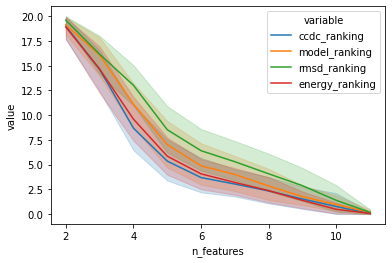

In [33]:
sns.lineplot(x='n_features', y='value', hue='variable', data=table[table['n_features'] < 12])